In [1]:
import albumentations
import albumentations.pytorch
import cv2
import torch
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import figure

import config
from models import Color2Embed

%matplotlib inline

In [2]:
model = Color2Embed(config.COLOR_EMBEDDING_DIM)
state_dict = torch.load('../trained_model/weights.pth')

/raid/aalekseev/_projects/Color2Embed_pytorch/color2embed/models.py:83: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(self.conv.weight)


In [3]:
model.load_state_dict(state_dict)
model.eval()
model = model.to('cuda')

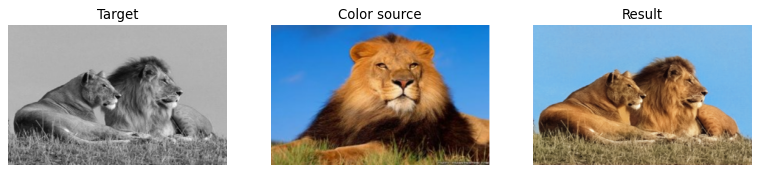

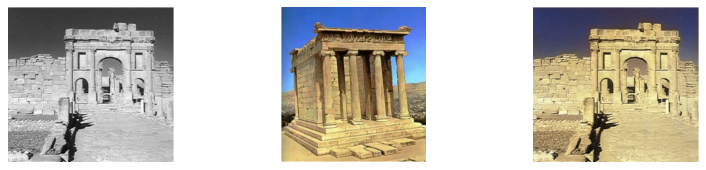

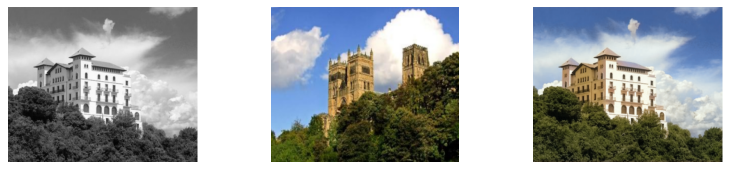

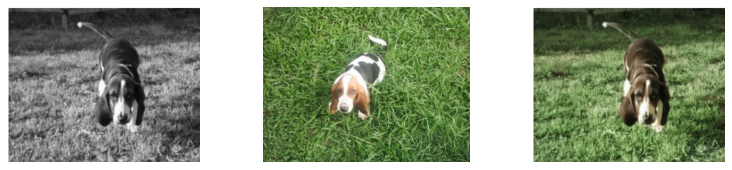

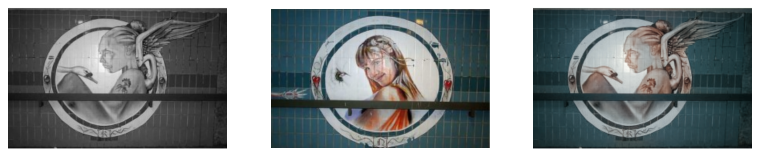

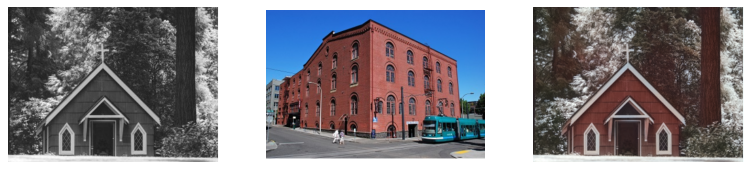

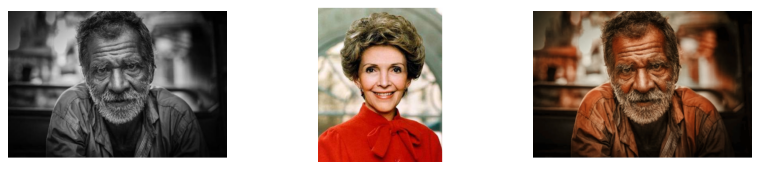

In [4]:
 transform_torch = albumentations.Compose(
    [
        albumentations.ToFloat(),
        albumentations.pytorch.ToTensorV2(),
    ]
)

image_count = 7
start_index = 1
for image_index in range(start_index, image_count+start_index):
    # read images
    ref_image = f'../test_images/test{image_index}_ref.png'
    target_image = f'../test_images/test{image_index}_target.png'
    color_src = cv2.imread(ref_image)
    grayscale_dst = cv2.imread(target_image)

    # convert to input
    color_src = cv2.resize(color_src, grayscale_dst.shape[:2], interpolation=cv2.INTER_LINEAR)
    color_src = transform_torch(image=color_src)['image']

    grayscale_dst = cv2.cvtColor(grayscale_dst, cv2.COLOR_BGR2LAB)
    grayscale_dst = transform_torch(image=grayscale_dst)['image']

    grayscale_dst = grayscale_dst[0, ...].unsqueeze(0)

    # predict ab channels
    with torch.no_grad():
        pab = model(grayscale_dst.to('cuda').unsqueeze(0), color_src.to('cuda').unsqueeze(0))

    # create predicted image
    merged_lab = torch.cat((grayscale_dst.to('cuda').unsqueeze(0), pab), 1)
    prgb = merged_lab.cpu().numpy()
    prgb = np.transpose(prgb, (0, 2, 3, 1))
    for i in range(prgb.shape[0]):
        prgb[i] = cv2.cvtColor(np.clip(prgb[i]*255, 0, 255).astype(np.uint8), cv2.COLOR_Lab2BGR)

        merged_lab[i] = transform_torch(image=prgb[i])['image'].to('cuda')/255.

    result_image = np.transpose((merged_lab.cpu().numpy()[0]*255).astype(np.uint8), (1, 2, 0))
    
    # show images
    figure(figsize=(12, image_count*3), dpi=80)

    plt.subplot(image_count, 3, 1+(image_index-start_index)*3)
    plt.axis('off')
    plt.imshow(cv2.imread(target_image)[...,::-1])
    if image_index == start_index:
        plt.title('Target')

    plt.subplot(image_count, 3, 2+(image_index-start_index)*3)
    plt.axis('off')
    plt.imshow(cv2.imread(ref_image)[...,::-1])
    if image_index == start_index:
        plt.title('Color source')

    plt.subplot(image_count, 3, 3+(image_index-start_index)*3)
    plt.axis('off')
    plt.imshow(result_image[...,::-1])
    if image_index == start_index:
        _ = plt.title('Result')

